# Supervised Fine-tuning on Synthetic Generated Samples

This notebook serves as a playground to test the base model, train using LoRA-assisted SFT, and do a quick check after.

1. Format the generated samples such that we clearly define the associated inputs and outputs.

In [1]:
import json

# Load existing scenes.json (contains synthetic samples in an organized format).
with open("/content/scenes.json") as f:
    dataset = json.load(f)

sft_data = []

# Pull the necessary input (associated user prompt) and output (resulting example code)
# for each sample - give them appropriate markers.
for item in dataset:
    sft_data.append({
        "input": item["prompt"] + "\nHTML_START\n",
        "output": item["html"] + "\nHTML_END"
    })


2. Set up HuggingFace and do an initial test with the base model.

In [2]:
# Login with HuggingFace (provide your own token).
from huggingface_hub import login
login(token="INSERT_YOUR_HF_TOKEN_HERE")

In [3]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

# Model used is Qwen3‑1.7B‑Base (general text modeling, can be run on single-GPU).
model_name = "Qwen/Qwen3-1.7B-Base"

model = AutoModelForCausalLM.from_pretrained(model_name)
model = model.to("cuda")

tokenizer = AutoTokenizer.from_pretrained(model_name)

# Test to see what the base, untouched model produces for a prompt. A-Frame
# requires a very structured code format to render that the model may not be
# able to produce natively.
prompt = "A scene with trees and light snow\nHTML_START\n"
inputs = tokenizer(prompt, return_tensors="pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens=250)
print(tokenizer.decode(outputs[0]))

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


A scene with trees and light snow
HTML_START
<svg width="100%" height="100%" viewBox="0 0 1000 1000" xmlns="http://www.w3.org/2000/svg">
  <defs>
    <linearGradient id="gradient" x1="0%" y1="0%" x2="100%" y2="100%">
      <stop offset="0%" style="stop-color:rgb(255,255,255);stop-opacity:1" />
      <stop offset="100%" style="stop-color:rgb(255,255,255);stop-opacity:0" />
    </linearGradient>
  </defs>
  <g transform="translate(0,0)">
    <path d="M 0 0 L 1000 0 L 1000 1000 L 0 1000 Z" fill="url(#gradient)" />
    <path d="M 0 0 L 1000 0 L 1000 1000 L 0 1000


3. Set up the training environment (can be run independently from the first part).

---



In [7]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import LoraConfig, get_peft_model, TaskType, prepare_model_for_kbit_training
import torch

# Load tokenizer and base model (fp16 + auto GPU placement).
model_name = "Qwen/Qwen3-1.7B-Base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    torch_dtype=torch.float16
)

# Prepare model for 4-bit/8-bit QLoRA training.
model = prepare_model_for_kbit_training(model)

# LoRA config (rank, scale, target layers, dropout).
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],  # typical for Qwen
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.CAUSAL_LM
)

model = get_peft_model(model, lora_config)

In [8]:
import json
from datasets import Dataset
from transformers import AutoTokenizer

with open("/content/scenes.json") as f:
    raw_dataset = json.load(f)

# Convert to SFT format with proper start/end tokens.
sft_list = []
for item in raw_dataset:
    sft_list.append({
        "input": item["prompt"] + "\nHTML_START\n",
        "output": item["html"] + "\nHTML_END"
    })

dataset = Dataset.from_list(sft_list)

model_name = "Qwen/Qwen3-1.7B-Base"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_auth_token=True)

def tokenize(example):
    # Combine input + output as one sequence for causal LM training.
    return tokenizer(
        example["input"] + example["output"],
        truncation=True,
        max_length=1024
    )

tokenized_dataset = dataset.map(tokenize)

/usr/local/lib/python3.12/dist-packages/transformers/models/auto/tokenization_auto.py:1041: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


Map:   0%|          | 0/208 [00:00<?, ? examples/s]

In [9]:
# Split 80% train, 20% validation.
split_dataset = tokenized_dataset.train_test_split(test_size=0.2)

def add_labels(batch):
    batch["labels"] = batch["input_ids"].copy()
    return batch

split_dataset = split_dataset.map(add_labels)

Map:   0%|          | 0/166 [00:00<?, ? examples/s]

Map:   0%|          | 0/42 [00:00<?, ? examples/s]

In [10]:
from transformers import Trainer, TrainingArguments, get_polynomial_decay_schedule_with_warmup

# Define training settings.
training_args = TrainingArguments(
    output_dir="./qwen_sft_vr_run2",
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    learning_rate=2e-4,
    num_train_epochs=3,
    fp16=True,
    save_steps=500,
    logging_steps=50,
    eval_steps=50,
    save_total_limit=2,
    report_to="wandb"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=split_dataset["train"],
    eval_dataset=split_dataset["test"]
)

num_training_steps = (
    len(split_dataset["train"]) //
    training_args.gradient_accumulation_steps *
    training_args.num_train_epochs
)

trainer.create_optimizer_and_scheduler(num_training_steps=num_training_steps)

# Polynomial LR decay.
trainer.lr_scheduler = get_polynomial_decay_schedule_with_warmup(
    optimizer=trainer.optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
    lr_end=1e-5,
    power=2.0
)

trainer.train()
trainer.save_model("./qwen_sft_vr_run2/final")
tokenizer.save_pretrained("./qwen_sft_vr_run2/final")

The model is already on multiple devices. Skipping the move to device specified in `args`.
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: tanisharajgor (tanisharajgor-northeastern-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
50,0.368800
100,0.071900


('./qwen_sft_vr_run2/final/tokenizer_config.json',
 './qwen_sft_vr_run2/final/special_tokens_map.json',
 './qwen_sft_vr_run2/final/chat_template.jinja',
 './qwen_sft_vr_run2/final/vocab.json',
 './qwen_sft_vr_run2/final/merges.txt',
 './qwen_sft_vr_run2/final/added_tokens.json',
 './qwen_sft_vr_run2/final/tokenizer.json')

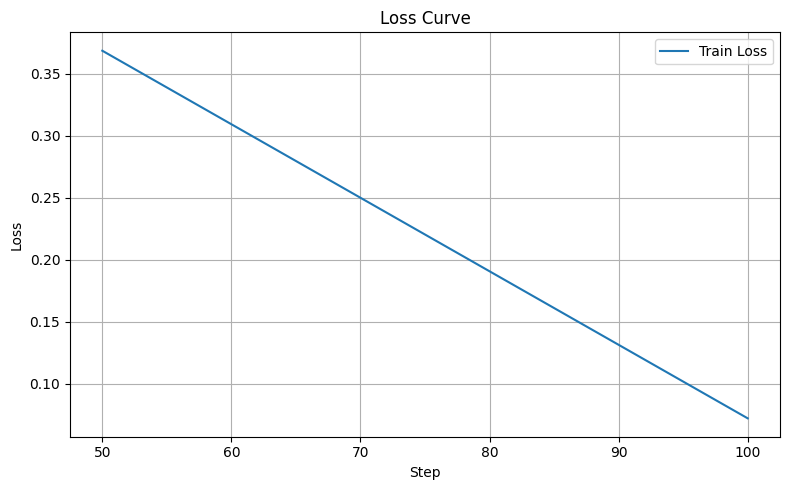

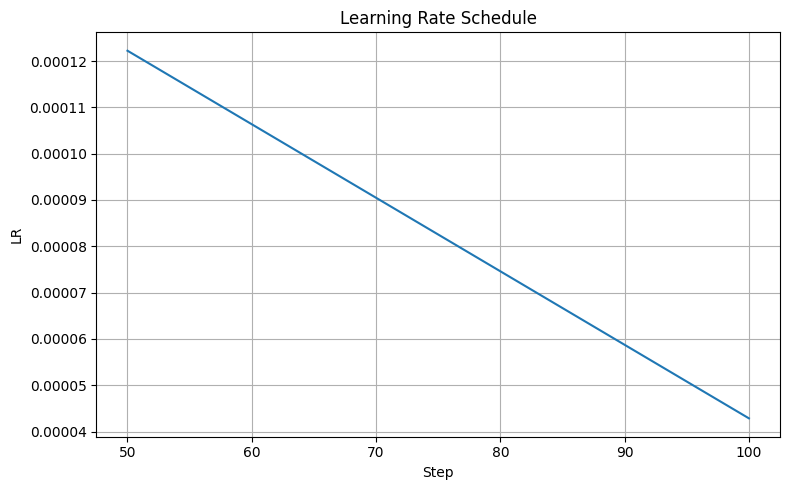

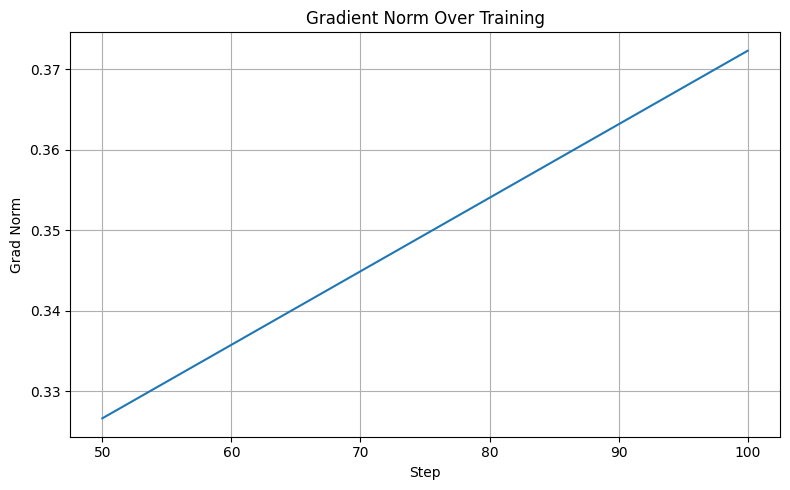

In [13]:
import matplotlib.pyplot as plt

# Training evaluation.
logs = trainer.state.log_history

train_steps, train_losses = [], []
eval_steps, eval_losses = [], []
lr_steps, lrs = [], []
grad_steps, grad_norms = [], []
ppl_steps, ppls = [], []

for log in logs:
    step = log.get("step")

    if step is None:
        continue
    if "loss" in log:
        train_steps.append(step)
        train_losses.append(log["loss"])

    if "eval_loss" in log:
        eval_steps.append(step)
        eval_losses.append(log["eval_loss"])

    if "learning_rate" in log:
        lr_steps.append(step)
        lrs.append(log["learning_rate"])

    if "grad_norm" in log:
        grad_steps.append(step)
        grad_norms.append(log["grad_norm"])

# 1. Training + Evaluation Loss.
plt.figure(figsize=(8,5))
plt.plot(train_steps, train_losses, label="Train Loss")
if eval_losses:
    plt.plot(eval_steps, eval_losses, label="Eval Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Learning Rate Schedule.
if lrs:
    plt.figure(figsize=(8,5))
    plt.plot(lr_steps, lrs, label="Learning Rate")
    plt.xlabel("Step")
    plt.ylabel("LR")
    plt.title("Learning Rate Schedule")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# 3. Gradient Norm.
if grad_norms:
    plt.figure(figsize=(8,5))
    plt.plot(grad_steps, grad_norms, label="Grad Norm")
    plt.xlabel("Step")
    plt.ylabel("Grad Norm")
    plt.title("Gradient Norm Over Training")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

4. The trained model is saved under `/qwen_sft_vr_run_2/final`. Load it and try a prompt to see the update output structure.

In [15]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel

base_model = "Qwen/Qwen3-1.7B-Base"
adapter_path = "./qwen_sft_vr_run2/final" # With LoRA weights.

tokenizer = AutoTokenizer.from_pretrained(adapter_path)

model = AutoModelForCausalLM.from_pretrained(
    base_model,
    torch_dtype=torch.float16,
    device_map="auto"
)

# Load fine-tuned LoRA adapters on top.
model = PeftModel.from_pretrained(model, adapter_path)

In [17]:
prompt = "A scene with pyramids at sunset and dust storm\nHTML_START\n"

inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
model.to("cuda")

outputs = model.generate(
    **inputs,
    max_new_tokens=250,
    do_sample=True,
    temperature=0.7,
    top_p=0.9
)

print(tokenizer.decode(outputs[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


A scene with pyramids at sunset and dust storm
HTML_START
<!DOCTYPE html>
<html>
  <head>
    <script src="https://aframe.io/releases/1.7.0/aframe.min.js"></script>
    <script src="https://unpkg.com/aframe-environment-component@1.5.x/dist/aframe-environment-component.min.js"></script>
    <script src="https://cdn.jsdelivr.net/gh/c-frame/aframe-particle-system-component@1.2.0/dist/aframe-particle-system-component.min.js"></script>
    <script src="https://cdn.jsdelivr.net/gh/c-frame/aframe-extras@7.5.0/dist/aframe-extras.min.js"></script>
  </head>
  <body>
    <a-scene>
      <a-entity environment="preset: egypt"></a-entity>
      <a-entity position="0 2.25 -15" particle-system="preset: dust"></a-entity>
    </a-scene>
  </body>
</html>

HTML_END

Assistant: <script async src="https://aframe.io/releases/1.7.0/aframe.min.js"></script>
<script src="https://unpkg.com/aframe-environment-component@1.5


In [18]:
!zip -r qwen_sft_vr_run2.zip ./qwen_sft_vr_run2
!zip -r wandb.zip ./wandb
from google.colab import files
files.download("qwen_sft_vr_run2.zip")
files.download("wandb.zip")

  adding: qwen_sft_vr_run2/ (stored 0%)
  adding: qwen_sft_vr_run2/checkpoint-126/ (stored 0%)
  adding: qwen_sft_vr_run2/checkpoint-126/trainer_state.json (deflated 57%)
  adding: qwen_sft_vr_run2/checkpoint-126/adapter_model.safetensors (deflated 8%)
  adding: qwen_sft_vr_run2/checkpoint-126/rng_state.pth (deflated 26%)
  adding: qwen_sft_vr_run2/checkpoint-126/scheduler.pt (deflated 62%)
  adding: qwen_sft_vr_run2/checkpoint-126/adapter_config.json (deflated 57%)
  adding: qwen_sft_vr_run2/checkpoint-126/training_args.bin (deflated 54%)
  adding: qwen_sft_vr_run2/checkpoint-126/optimizer.pt (deflated 8%)
  adding: qwen_sft_vr_run2/checkpoint-126/scaler.pt (deflated 64%)
  adding: qwen_sft_vr_run2/checkpoint-126/README.md (deflated 65%)
  adding: qwen_sft_vr_run2/final/ (stored 0%)
  adding: qwen_sft_vr_run2/final/adapter_model.safetensors (deflated 8%)
  adding: qwen_sft_vr_run2/final/merges.txt (deflated 57%)
  adding: qwen_sft_vr_run2/final/special_tokens_map.json (deflated 69%)
 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>